In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from importlib import reload
from ea_data_loader import load_ea_data
import math
import copy

%load_ext autoreload
%autoreload 2

tfd = tfp.distributions
tfb = tfp.bijectors
dtype = np.float32
plt.style.use('ggplot')

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data = [load_ea_data(vid=v, filter_subs=True, platform='camh')[0] for v in [0, 1]]
for d in data: print(d.shape)

(332, 400, 85)
(332, 400, 73)


In [ ]:
from shared_gpfa import SharedGpfa

subs = Ellipsis
# subs = range(5)
train = [d[subs] for d in data]
m, q, _ = train[0].shape
for t in train: print(t.shape)

p = 20
model = SharedGpfa(m, q, p)
l = model.fit(
    train_data=train,
    n_iters=500,
    learning_rate=0.08,
    tensorboard=False,
    fa_init=True,
    reg=0.)

(332, 400, 85)
(332, 400, 73)


  0%|          | 0/500 [00:00<?, ?it/s]

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [ ]:
print(model.joint)
plt.style.use('ggplot')
plt.plot(l)
plt.yscale('log')

In [14]:
# SRM
import brainiak.funcalign.srm 

train_srm = np.concatenate(train, axis=-1)
train_srm = [d for d in train_srm]

srm = brainiak.funcalign.srm.SRM(n_iter=30, features=p)
srm.fit(train_srm)

SRM(comm=<mpi4py.MPI.Intracomm object at 0x7f9ac80bc4e0>, features=20,
    n_iter=30, rand_seed=0)

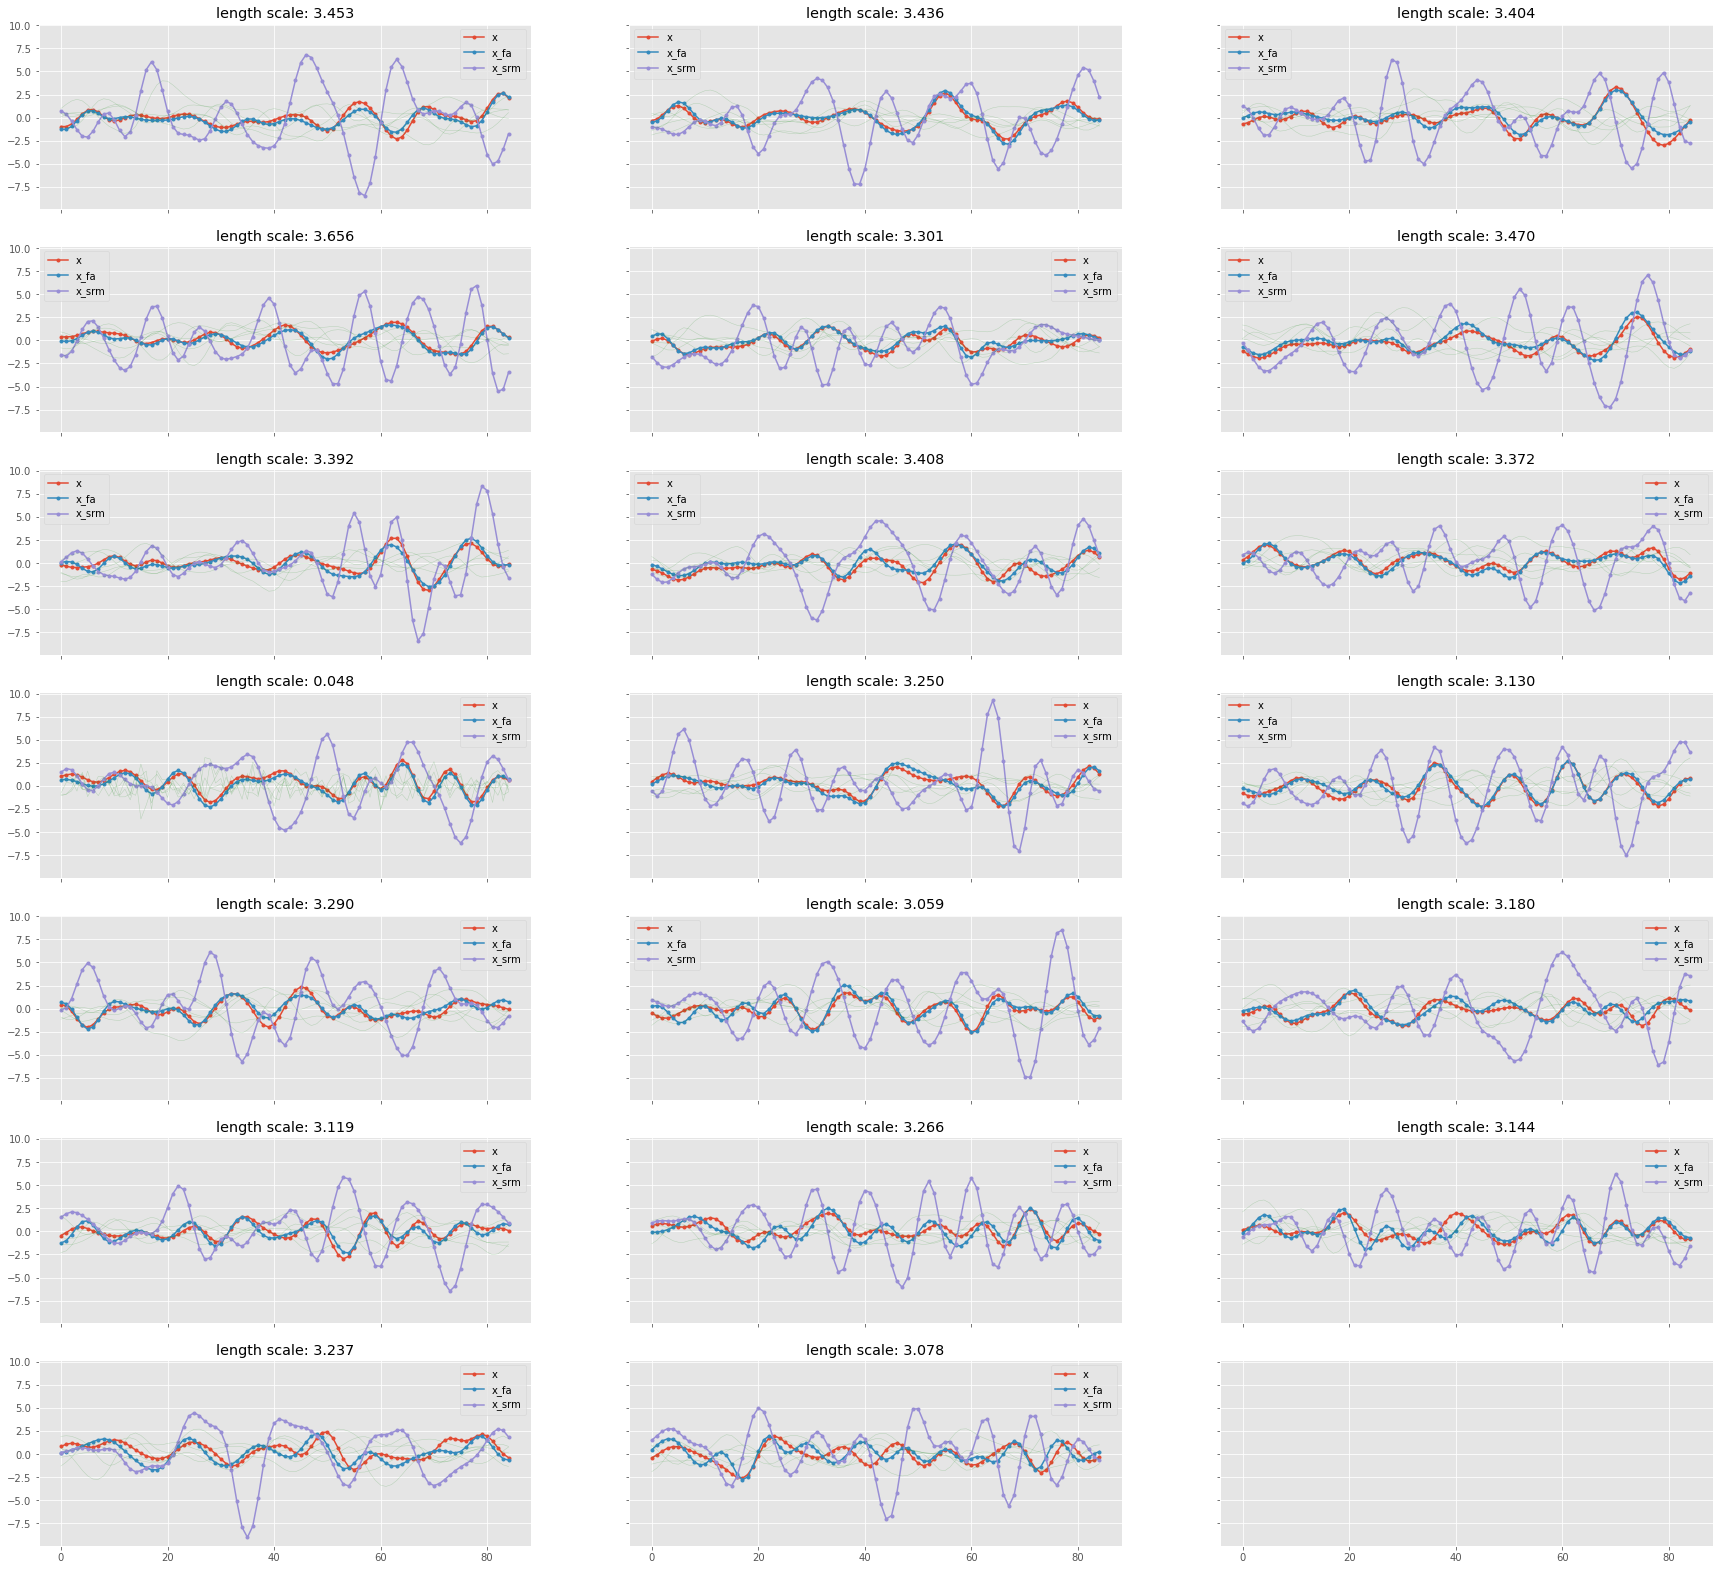

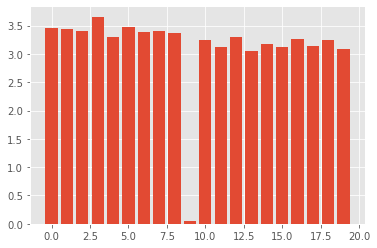

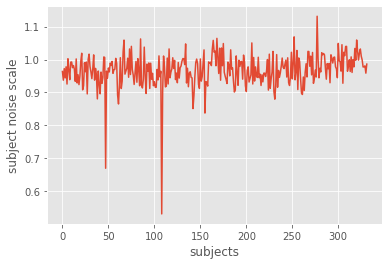

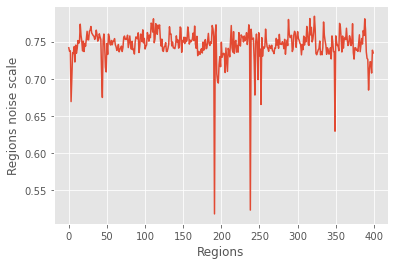

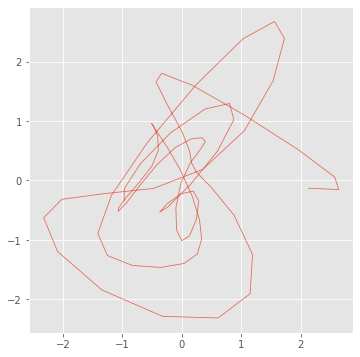

In [15]:
sample = 0

x = model.vars['x'][sample].numpy()
xsample = model.joint[sample].sample(5)['x'].numpy().transpose(1, 2, 0)
xfa, w_fa = model.factor_analysis(train)
x_ls = model.least_square(train)
x_srm = srm.s_[:, :x.shape[-1]]

length_scale = tf.convert_to_tensor(model.vars['length_scale']).numpy()

ncols = 3
nrows = math.ceil(model.p / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(10 * ncols, nrows * 4), sharex=True, sharey=True)
for _x, _x_fa, _x_ls, _xsample, _x_srm, _lenscale, ax in zip(x, xfa[sample], x_ls[sample], xsample, x_srm, length_scale, axs.flat):
    ax.plot(_x, marker='.', label='x')
    ax.plot(_x_fa, marker='.', label='x_fa')
    # ax.plot(_x_ls, marker='.', label='x_ls')
    ax.plot(_x_srm, marker='.', label='x_srm')
    ax.plot(_xsample, color='g', lw=0.5, alpha=0.2)
    ax.set_title(f'length scale: {_lenscale:.3f}')
    ax.legend()

plt.figure()
plt.bar(np.arange(model.p), length_scale)

plt.figure()
plt.plot(tf.convert_to_tensor(model.vars['subject_noise_scale']))
plt.xlabel('subjects')
plt.ylabel('subject noise scale')

plt.figure()
plt.plot(tf.convert_to_tensor(model.vars['roi_noise_scale']))
plt.xlabel('Regions')
plt.ylabel('Regions noise scale')

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(*x[0:2], lw=0.8, alpha=0.8)
ax.set_aspect('equal', 'box')


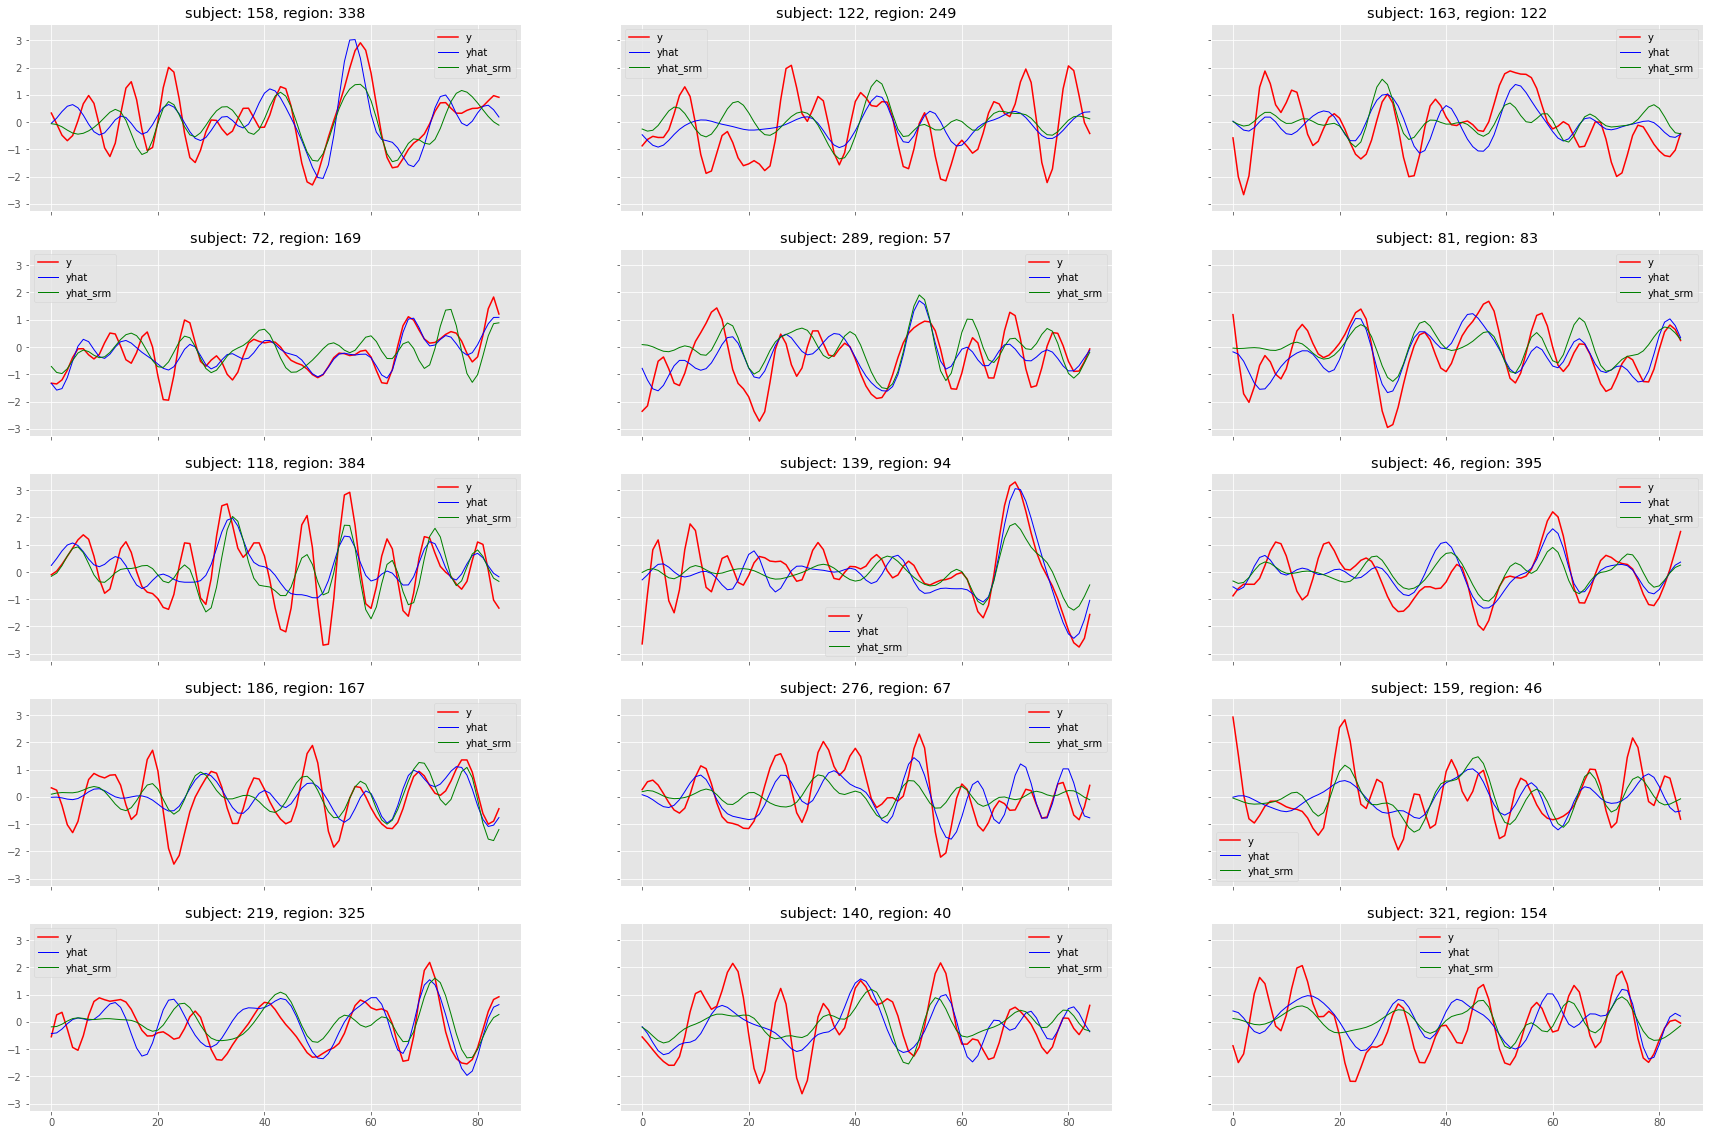

In [16]:
sample = 0

y = train[sample]
y_hat = model.vars['w'].numpy() @ model.vars['x'][sample].numpy()
y_hat_srm = np.stack(srm.w_, axis=0) @ srm.s_[:, :y.shape[-1]]

nrows = 5
ncols = 3

fig, axs = plt.subplots(nrows, ncols, figsize=(10 * ncols, 4 * nrows), sharex=True, sharey=True)
for ax in axs.flat:
    sub = np.random.randint(m)
    vox = np.random.randint(q)    
    ax.plot(y[sub, vox, :], marker='', label='y', color='red', lw=1.5)
    ax.plot(y_hat[sub, vox, :], marker='', label='yhat', color='blue', lw=1)
    ax.plot(y_hat_srm[sub, vox, :], marker='', label='yhat_srm', color='green', lw=1)
    ax.legend()
    ax.set_title(f'subject: {sub}, region: {vox}')


Text(0.5, 0, 'Subjects')

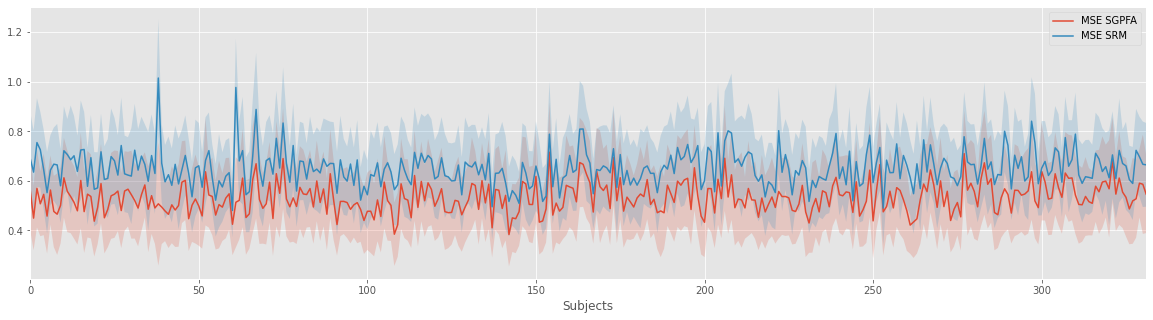

In [17]:
def mse(y_true, y_hat):
    se = (y_true - y_hat) ** 2
    mse = se.mean(-1)
    return mse, mse.mean(-1), mse.std(-1)

fig, ax = plt.subplots(figsize=(20, 5))
_, mse_mean, mse_std = mse(y, y_hat)
ax.plot(mse_mean, label='MSE SGPFA')
ax.fill_between(np.arange(m), mse_mean - mse_std, mse_mean + mse_std, alpha=0.2)

_, mse_mean, mse_std = mse(y, y_hat_srm)
ax.plot(mse_mean, label='MSE SRM')
ax.fill_between(np.arange(m), mse_mean - mse_std, mse_mean + mse_std, alpha=0.2)

ax.legend()
ax.set_xlim(0, m-1)
ax.set_xlabel('Subjects')

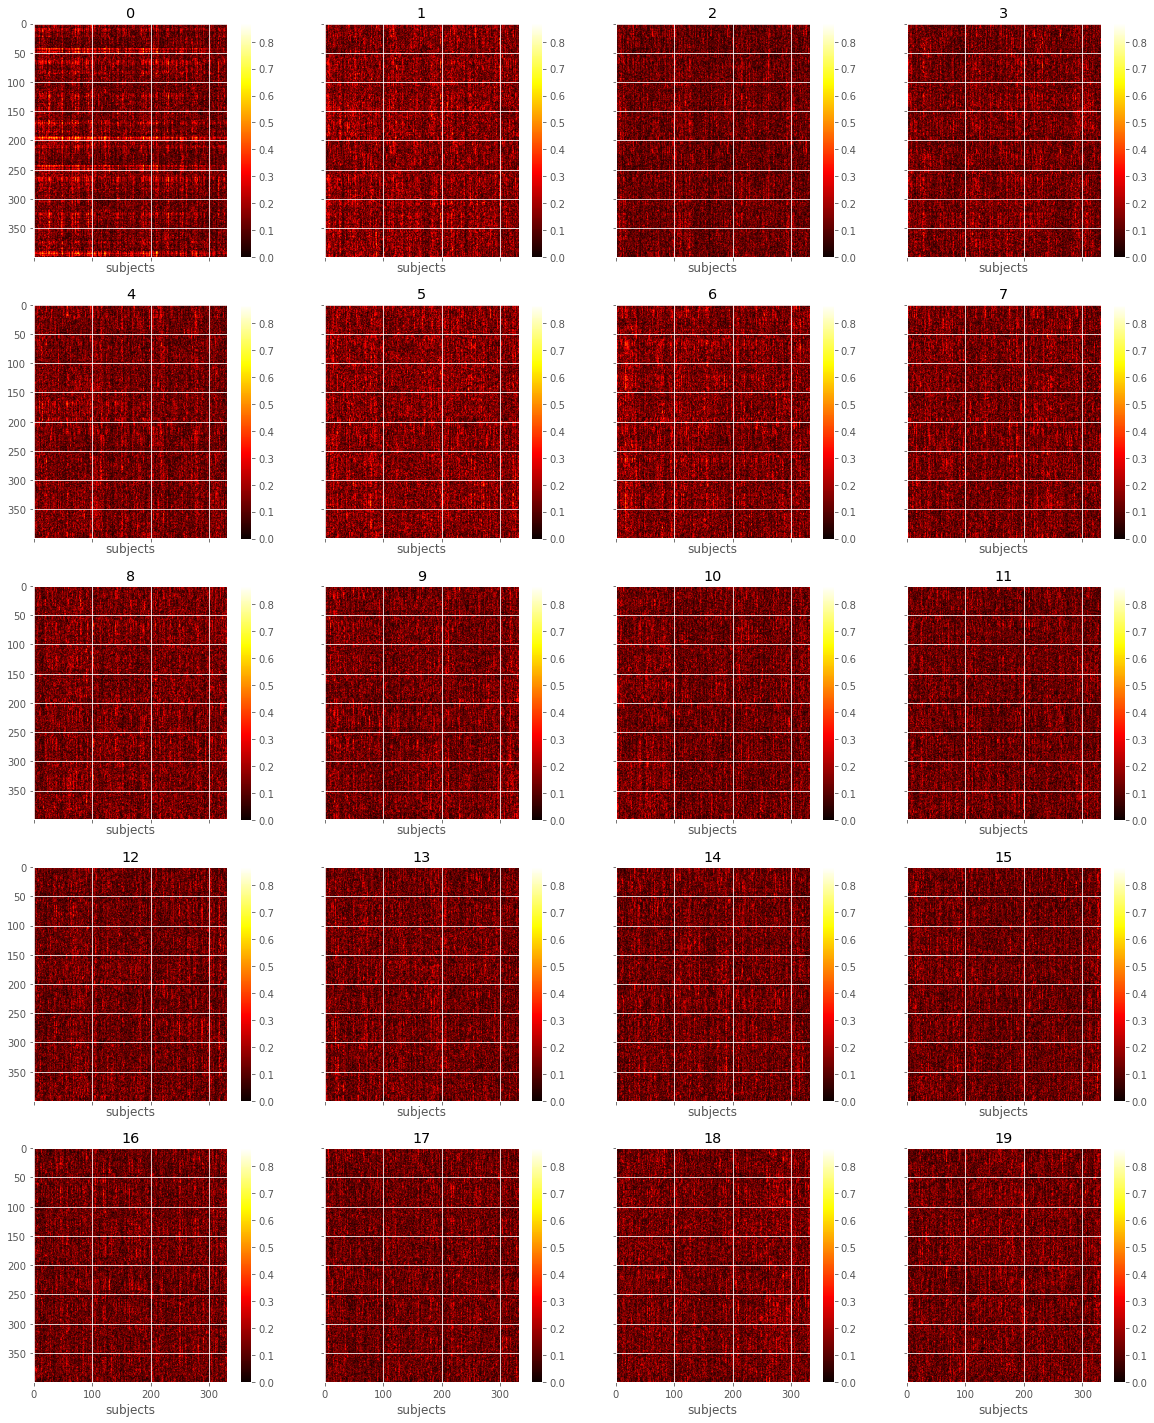

In [18]:
w = model.vars['w'].numpy()
# w = np.stack(srm.w_, axis=0)

ncols = 4
nrows = math.ceil(p / 4)

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5), sharex=True, sharey=True)
# fig.suptitle(f'reg = {model.reg}')
vmax = w.max()
for _w, ax, comp in zip(w.transpose((2,1,0)), axs.flat, np.arange(p)):
    im = ax.imshow(np.abs(_w), cmap='hot', vmin=0, vmax=vmax)
    ax.set_title(comp)
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('subjects')

In [1]:
w_sgpfa = model.vars['w'].numpy()
w_srm = np.stack(srm.w_, axis=0)

fig, ax = plt.subplots(figsize=(30,10))

for w, c in zip((w_sgpfa, w_srm), ('b', 'r')):
    roi_vars = w.var(axis=0)
    roi_vars_centered = roi_vars - roi_vars.mean(axis=0)
    ax.plot(roi_vars_centered, 'o', color=c, mew=0, ms=5, alpha=0.2)
    ax.plot(roi_vars_centered.mean(-1), color=c)



fig, ax = plt.subplots(figsize=(30,10))
ax.matshow(roi_vars_centered, aspect='auto')

NameError: name 'model' is not defined

In [19]:
# w, l = model.add_subject(data[0:10], 0)
# print(l)

In [21]:
from ea_data_loader import load_ea_data

valid = [load_ea_data(vid=3, filter_subs=True, platform='camh')[0]]

valid_srm = np.concatenate(valid, axis=-1)
valid_srm = [d for d in valid_srm]


In [22]:
from shared_gpfa import SharedGpfa

xlist, l = model.add_video(valid, n_iters=1000, learning_rate=0.05, tensorboard=False, fa_init=False)
# train_subs = [i for i in range(m) if i != 1]
# x = model.add_video(valid, subs=train_subs, fa_init=False)

In [23]:
xsrm_test = srm.transform(valid_srm)
xsrm_test = np.stack(xsrm_test, 0).mean(0)

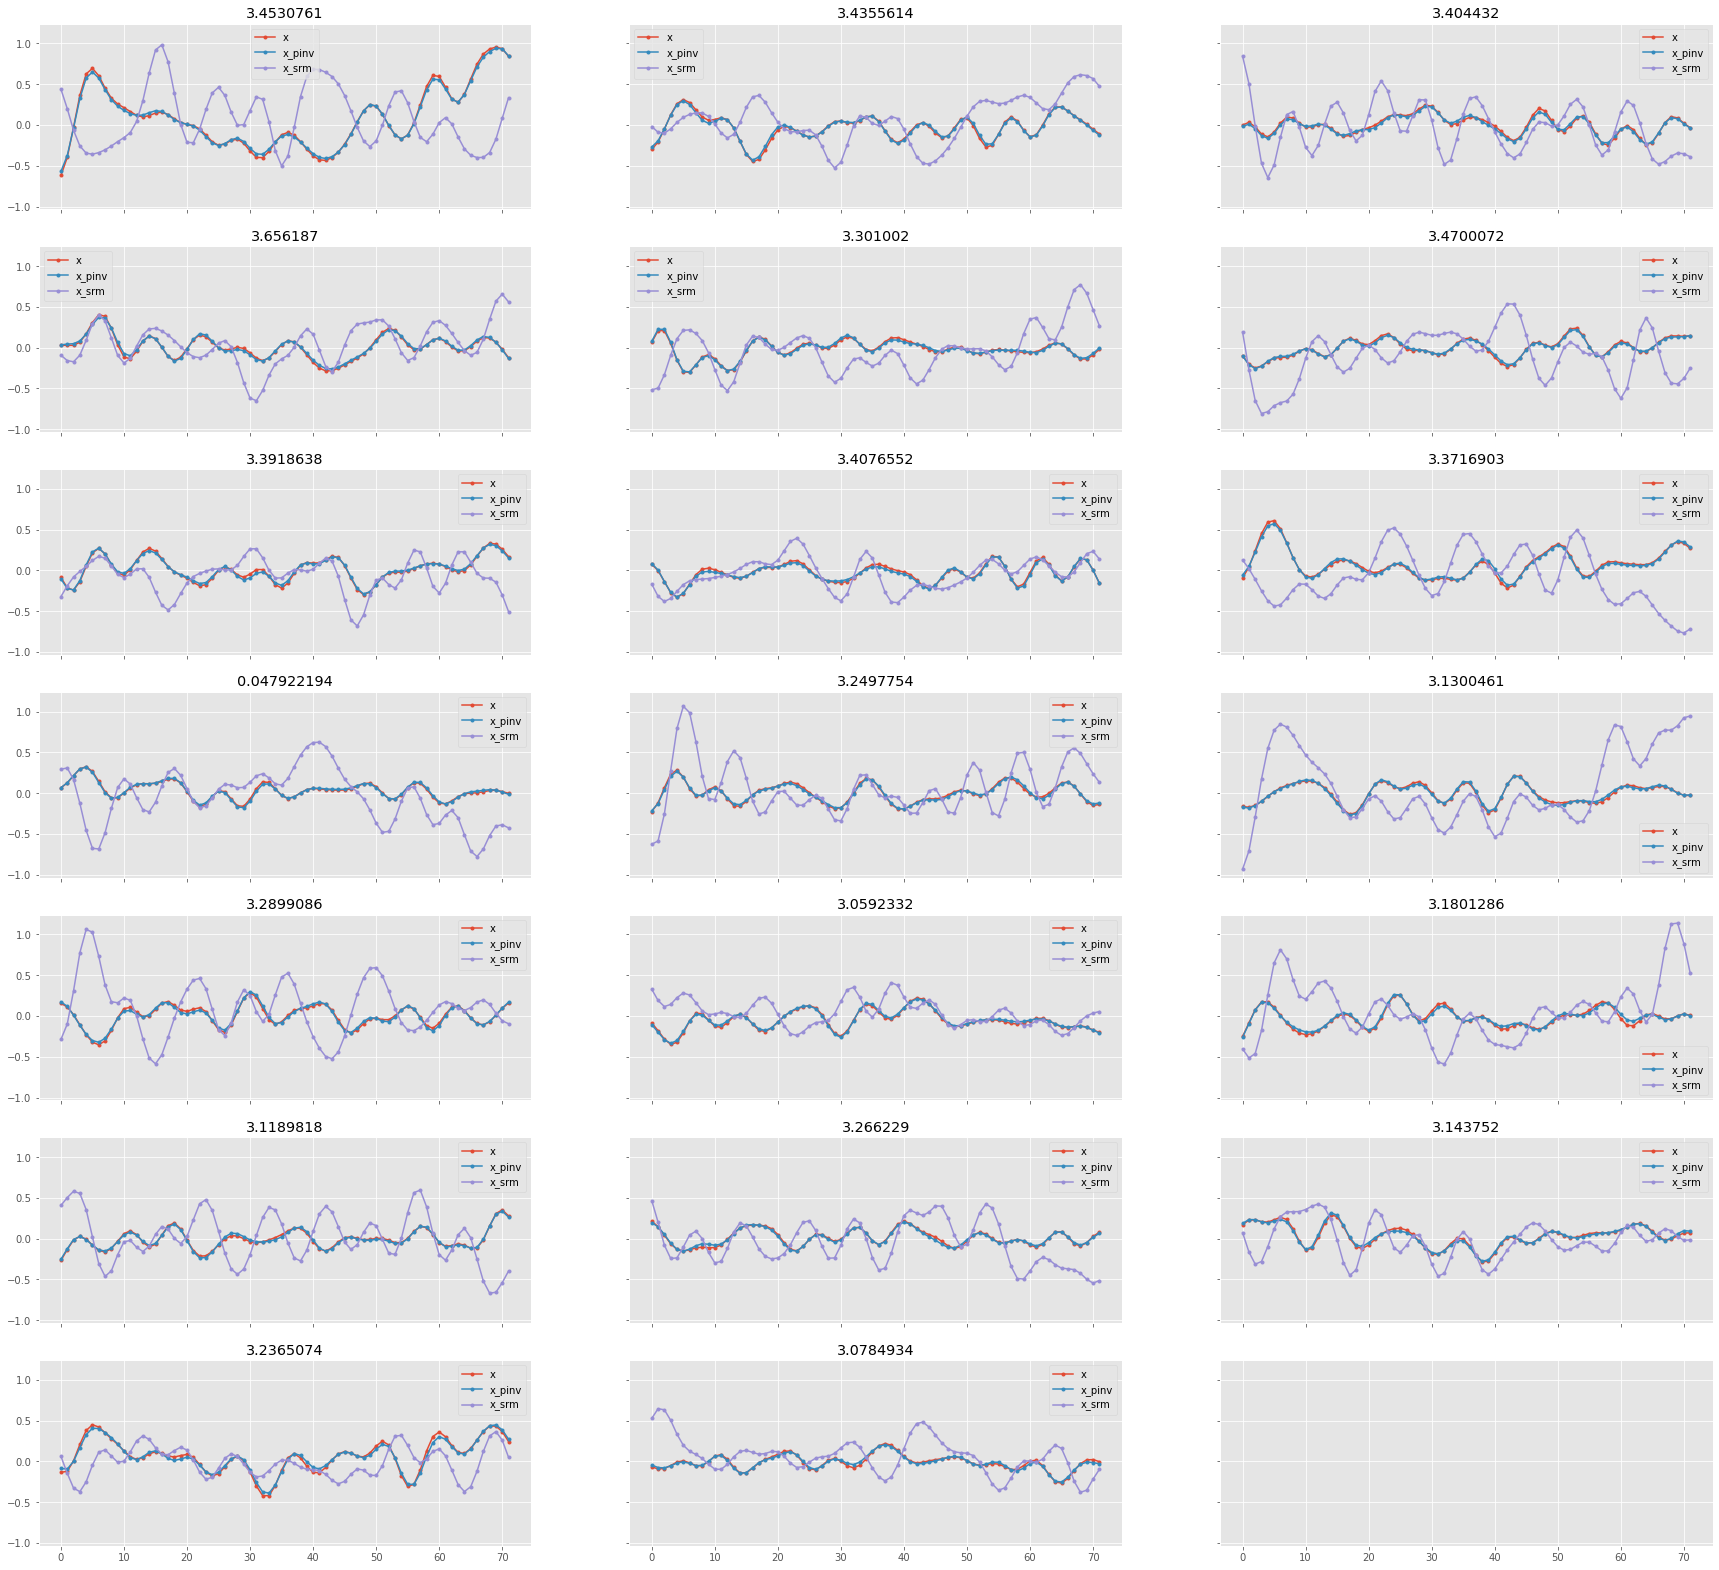

In [24]:
length_scale = tf.convert_to_tensor(model.vars['length_scale']).numpy()

x = xlist[0].numpy()
x_pinv = model.least_square(valid)[0]

n_rows = model.p//3 + 1
fig, axs = plt.subplots(n_rows, 3, figsize=(30, n_rows * 4), sharex=True, sharey=True)
for _x, _x_pinv, _xsrm, l, ax in zip(x, x_pinv, xsrm_test, length_scale, axs.flat):
    ax.plot(_x, marker='.', label='x' )
    ax.plot(_x_pinv, marker='.', label='x_pinv')
    ax.plot(_xsrm, marker='.', label='x_srm')
    
    ax.set_title(l)
    ax.legend()

# plt.figure()
# plt.bar(np.arange(model.p), length_scale)

# plt.figure()
# plt.plot(tf.convert_to_tensor(model.vars['subject_noise_scale']))
# plt.xlabel('subjects')
# plt.ylabel('subject noise scale')

# plt.figure()
# plt.plot(tf.convert_to_tensor(model.vars['roi_noise_scale']))
# plt.xlabel('Regions')
# plt.ylabel('Regions noise scale')

# fig, ax = plt.subplots(figsize=(6,6))
# ax.plot(*x[0:2], lw=0.8, alpha=0.8)
# ax.set_aspect('equal', 'box')

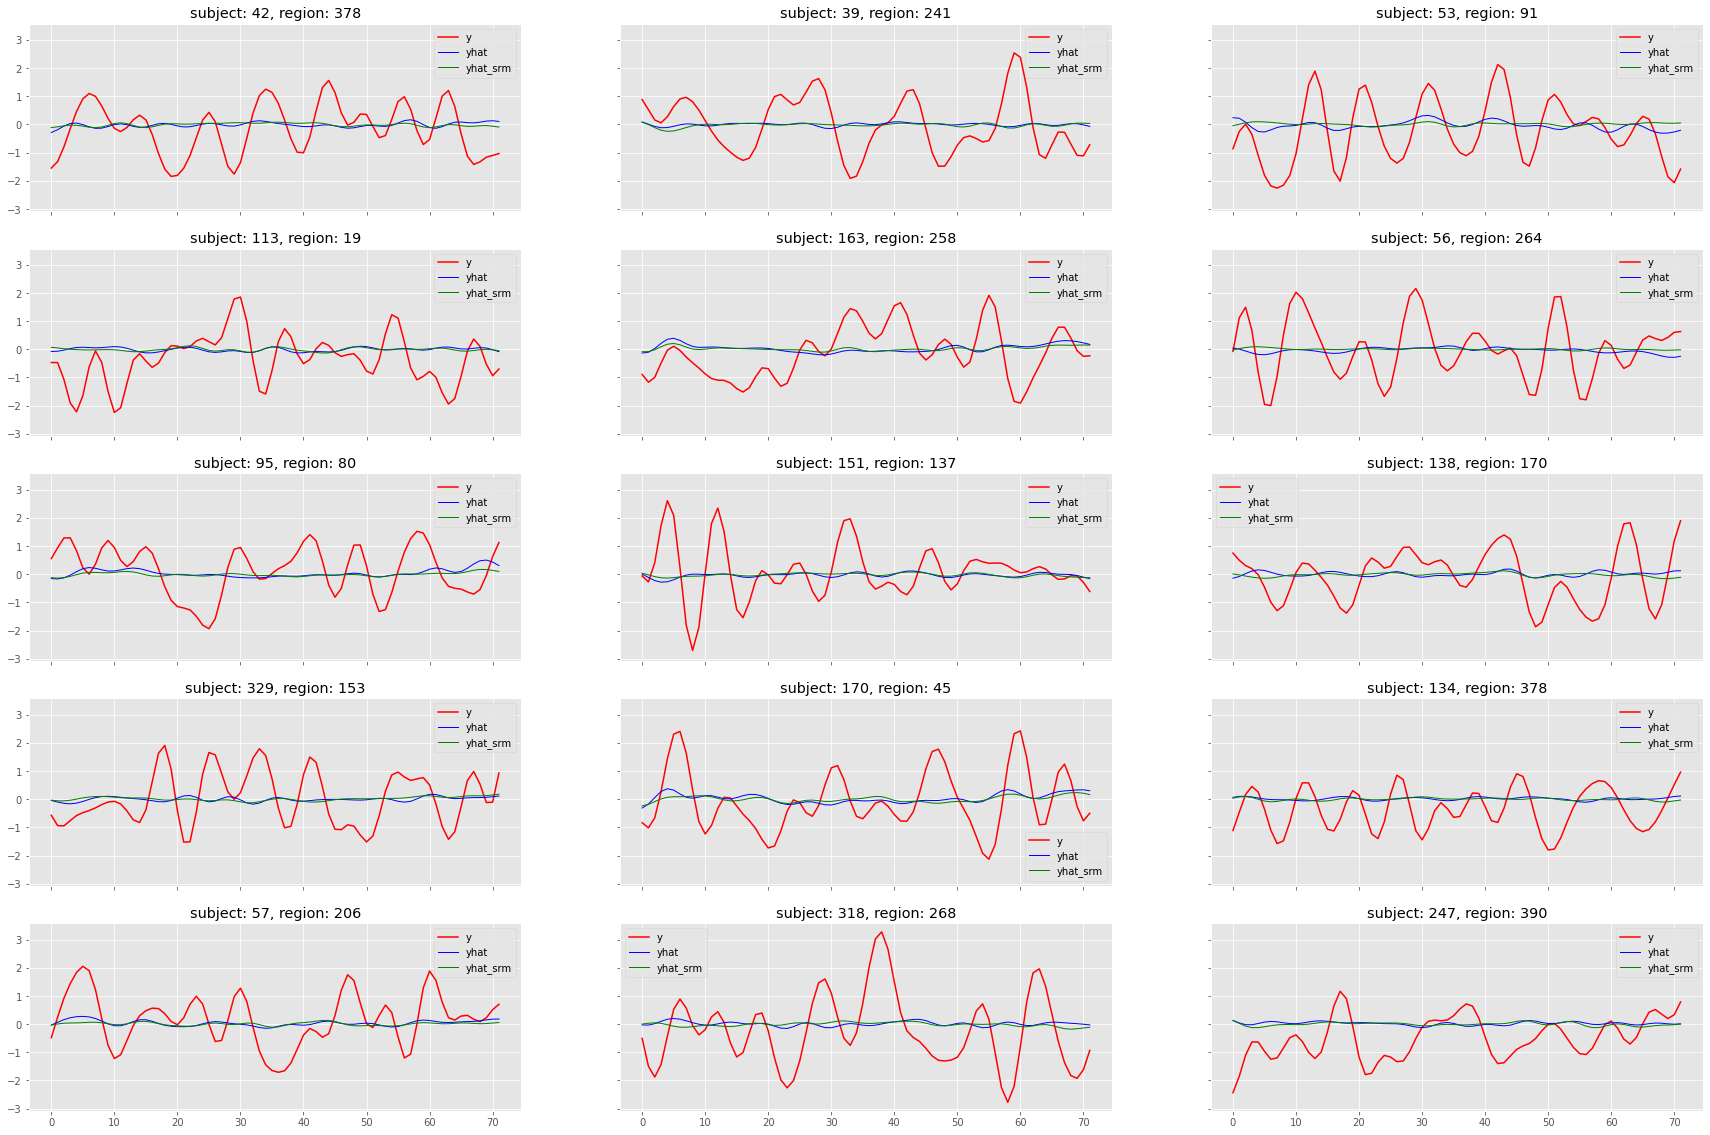

In [25]:
y_hat = model.vars['w'].numpy() @ xlist[0].numpy()
y = valid[0]
y_hat_srm = np.stack(srm.w_, axis=0) @ xsrm_test[:, :y.shape[-1]]

nrows = 5
ncols = 3

fig, axs = plt.subplots(nrows, ncols, figsize=(10 * ncols, 4 * nrows), sharex=True, sharey=True)
for ax in axs.flat:
    sub = np.random.randint(m)
    vox = np.random.randint(q)    
    ax.plot(y[sub, vox, :], marker='', label='y', color='red', lw=1.5)
    ax.plot(y_hat[sub, vox, :], marker='', label='yhat', color='blue', lw=1)
    ax.plot(y_hat_srm[sub, vox, :], marker='', label='yhat_srm', color='green', lw=1)
    ax.legend()
    ax.set_title(f'subject: {sub}, region: {vox}')

Text(0.5, 0, 'Subjects')

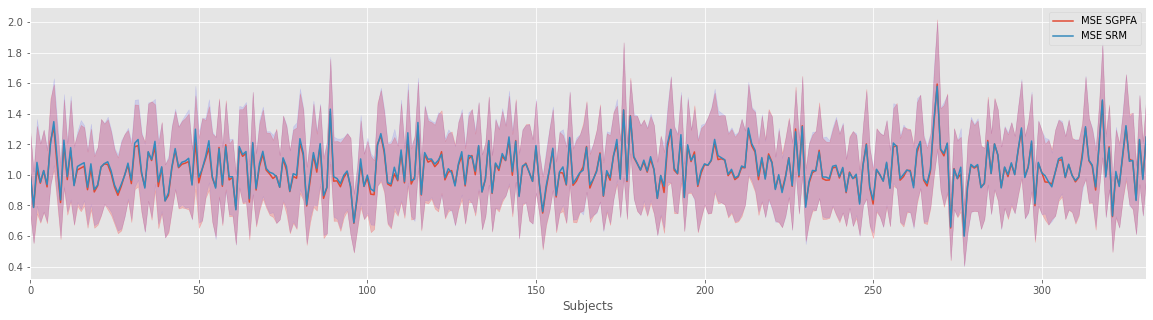

In [27]:
fig, ax = plt.subplots(figsize=(20, 5))
_, mse_mean, mse_std = mse(y, y_hat)
ax.plot(mse_mean, label='MSE SGPFA')
ax.fill_between(np.arange(m), mse_mean - mse_std, mse_mean + mse_std, color='red', alpha=0.2)

_, mse_mean, mse_std = mse(y, y_hat_srm)
ax.plot(mse_mean, label='MSE SRM')
ax.fill_between(np.arange(m), mse_mean - mse_std, mse_mean + mse_std, color='blue', alpha=0.1)

ax.legend()
ax.set_xlim(0, m-1)
ax.set_xlabel('Subjects')

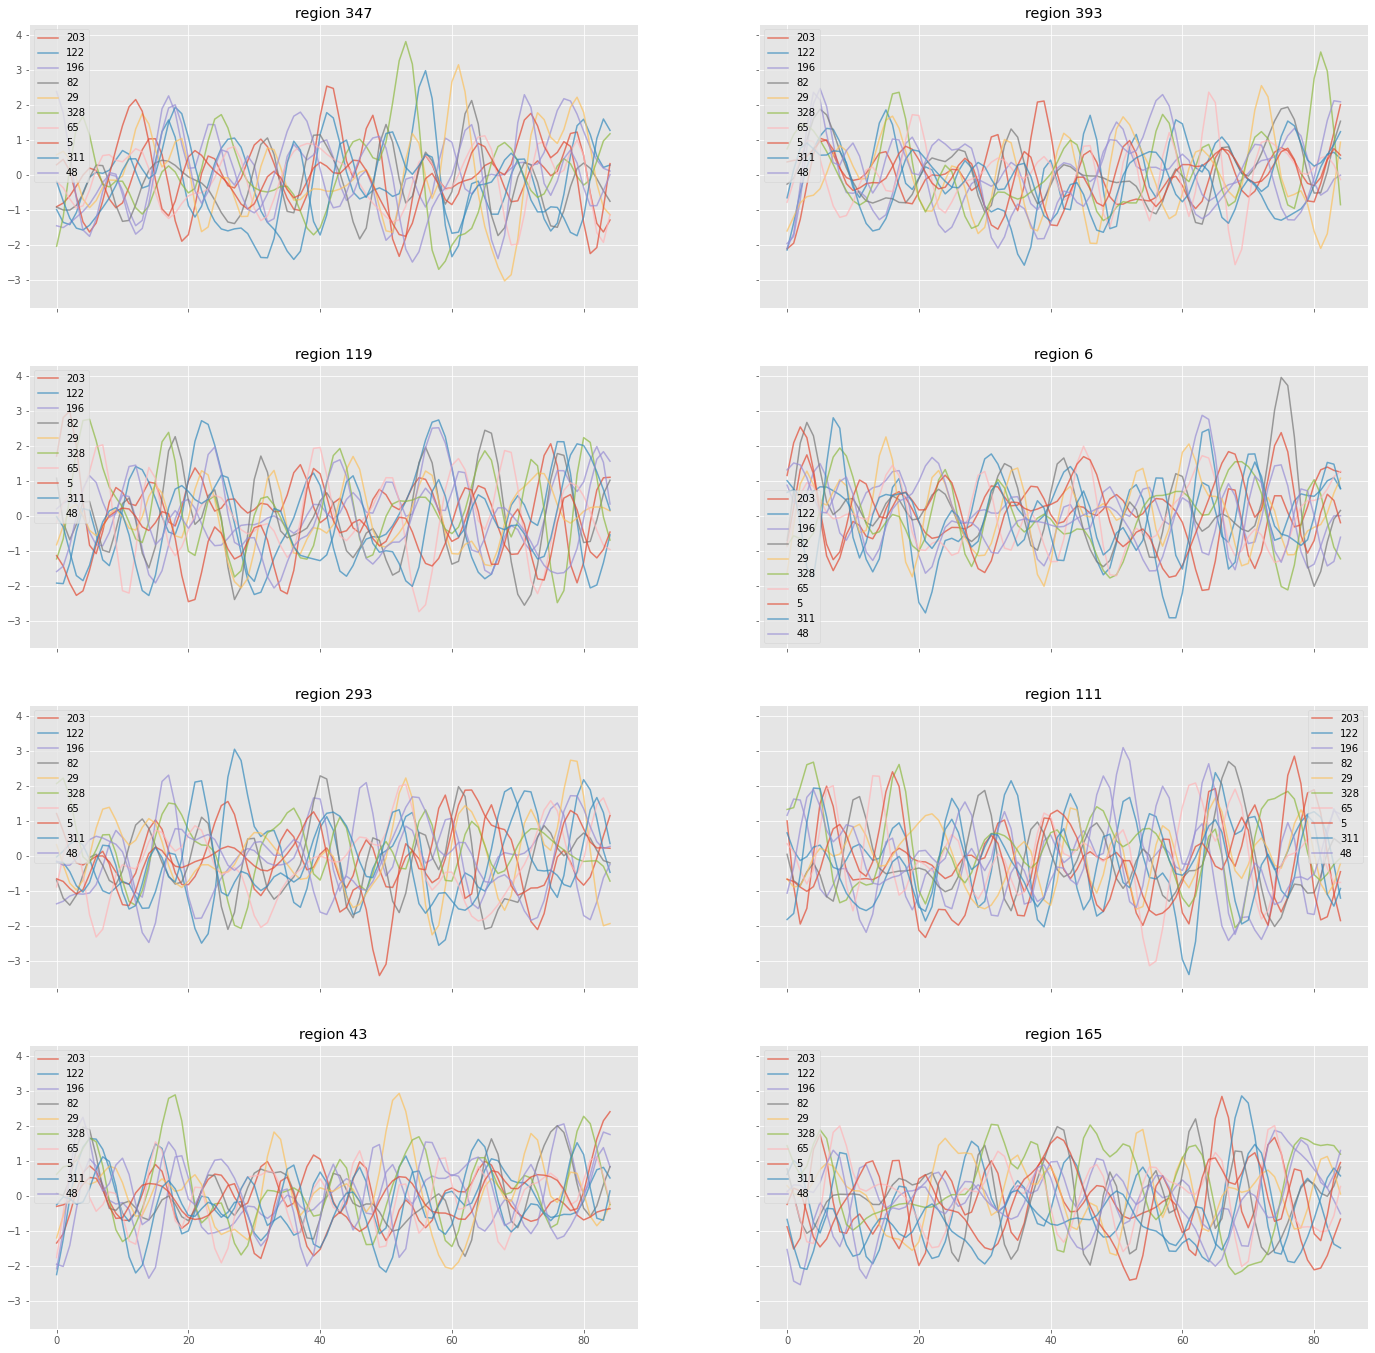

In [28]:
n_rows = 4
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows), sharex=True, sharey=True)

y = data[0]
subs = np.random.randint(m, size=10)
vox = np.random.randint(q, size=20)

for ax, v in zip(axs.flat, vox):
    ax.plot(y[subs, v, :].T, alpha=0.7)
    ax.set_title(f'region {v}')
    ax.legend(subs)
